# Beta Bank Customer Retention Analysis

Beta Bank has found that a small portion of customers are leaving every month. Analysts at the bank determined that it is cheaper to retain the customers it has than to attract new customers. In light of this finding, Beta Bank requested that we create a model that can predict whether a customer will leave the bank soon. Using data on clients' past behavior and termination of contracts with the bank, our task if to build a model with an F1 score of at least .59. In order to meet this requirement, we will test various classification models and determine the probability threshold that allows for the optimal F1 score.

**Table of Contents:**
* [1 Import Libraries and Prepare Data](#1)
    * [1.1 Import Libraries](#1.1)
    * [1.2 Import Data](#1.2)
    * [1.3 Examine Data](#1.3)
    * [1.4 Check for Duplicates](#1.4)
    * [1.5 Remove Unnecessary Columns](#1.5)
    * [1.6 Handle Missing Values](#1.6)
    * [1.7 Convert Columns to Proper Type](#1.7)
    * [1.8 OHE the Categorical Variables](#1.8)
    * [1.9 Section Summary](#1.9)
* [2 Obtain the Best Model](#2)
    * [2.1 Split the Data](#2.1)
    * [2.2 Scale the Features](#2.2)
    * [2.3 Check the Balance of Classes](#2.3)
    * [2.4 Initial Testing Without Considering Class Imbalance](#2.4)
    * [2.5 Balanced Models](#2.5)
        * [2.5.1 Balanced Models by Class Weight](#2.5.1)
        * [2.5.2 Create Upsampled and Downsampled Datasets](#2.5.2)
        * [2.5.3 Balanced Models by Upsampling](#2.5.3)
        * [2.5.4 Balanced Models by Downsampling](#2.5.4)
        * [2.5.5 Balanced Models Conclusion](#2.5.5)
    * [2.6 Obtain Best Random Forest Model](#2.6)
        * [2.6.1 Tune Hyperparameters for Best Model](#2.6.1)
        * [2.6.2 Attempt Optimization by Threshold Moving](#2.6.2)
        * [2.6.3 Visualize the Results - Confusion Matrices](#2.6.3)
        * [2.6.4 Visualize the Results - ROC Graph](#2.6.4)
        * [2.6.7 Highest Recall Score](#2.6.5)
        * [2.6.8 Best Model Conclusion](#2.6.6)
* [3 Conclusion](#3)

## Import Libraries and Prepare Data<a class="anchor" id='1'></a>

### Import Libraries<a class="anchor" id='1.1'></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import Normalizer
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from matplotlib import pyplot as plt
import seaborn as sn
import warnings
warnings.filterwarnings('ignore')

### Import Data<a class="anchor" id='1.2'></a>

In [2]:
#Import the dataset and save as DataFrame.
try:
    df = pd.read_csv('/datasets/Churn.csv')
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/Churn.csv')

### Examine Data<a class="anchor" id='1.3'></a>

In [3]:
#Examine DataFrame info and sample.
print(df.info())
print()
display(df.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB
None



,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


1.3 Notes: In order to build a model that is adept at determining whether a client will terminate their contract with Beta Bank, we were provided with a dataset that is comprised of 14 columns and 10,000 observations. The columns are broken down as follows:

* RowNumber: Data string index from original dataset.

* CustomerId: Unique customer identifier.

* Surname: Customer's last name.

* CreditScore: Customer's credit score.

* Geography: County in which the customer resides.

* Gender: Customer's gender.

* Age: Customer's age.

* Tenure: Period of maturation for a customer’s fixed deposit (years).

* Balance: Customer's account balance.

* NumOfProducts: Number of banking products used by the customer.

* HasCrCard: Whether the customer has a credit card (1 = yes).

* IsActiveMember: Whether customer is an active member.

* EstimatedSalary: Customer's estimated salary.

* Exited: Whether the customer has left (1 = yes).

Since we are trying to build a model to determine whether a customer will leave the bank, the target information from this dataset is contained in the 'Exited' column. We will extract the data from this column when we split the dataset in a later section. Whereas that will leave us will 13 columns to use as features, some of these column are irrelevant to the investigation - that is, the 'RowNumber', 'CustomerID', and 'Surname' columns. Since these columns will not be of use to the model, we will remove them from the dataset, leaving us with 10 features to train our model with.

Additional points worth nothing are that there seems to be missing data, and the scale of values are different across features. Regarding the former, there appear to be NaNs in the 'Tenure' column. We will attempt to fill these in a later subsection, Regarding the latter, notice that a person's age is generally represented as a value with 1 to 3 digits, whereas 'EstimatedSalary' values are much larger. In order to not assign greater important to one feature over the other because of a difference in value scales, we will standardize the relevant features in a later subsection. Finally, it's important to also notice that the Geography and Gener columns are filled with categorical variables; in order to allow the model to use the relevant data, we will One-Hot Encode these variables.

### Check for Duplicates<a class="anchor" id='1.4'></a>

In [4]:
#Obtain sum of duplicates
print('The number of duplicates in the DataFrame is: {}'.format(df.duplicated().sum()))

The number of duplicates in the DataFrame is: 0


### Remove Unnecessary Columns<a class="anchor" id='1.5'></a>

In [5]:
#Remove 'CustomerId', 'RowNumber', and 'Surname' columns
df.drop(columns=['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)

1.5 Notes: The above columns were removed from the DataFrame as they are uninformative. Given the content of the columns, it is unreasonable to expect that there would be any correlation between those values and whether an individual terminates a bank contract.

### Handle Missing Values<a class="anchor" id='1.6'></a>

In [6]:
#Check if there is correlation to replace NaNs in Tenure with.
print("Correlation Series for Tenure Column:\n")
print(df.corrwith(df.Tenure))

Correlation Series for Tenure Column:

CreditScore       -0.000062
Age               -0.013134
Tenure             1.000000
Balance           -0.007911
NumOfProducts      0.011979
HasCrCard          0.027232
IsActiveMember    -0.032178
EstimatedSalary    0.010520
Exited            -0.016761
dtype: float64


In [7]:
#Based on loose correlations above, fill NaNs with the mean of grouped columns with highest degree of correlation.
df['Tenure'] = df['Tenure'].fillna(df.groupby(['IsActiveMember', 'HasCrCard', 'NumOfProducts'])['Tenure'].transform('mean').round(0))

In [8]:
print("Number of NaNs remaining in 'Tenure' column: {}".format(len(df.loc[df['Tenure'].isna()])))

Number of NaNs remaining in 'Tenure' column: 0


1.6 Notes: From looking at the DataFrame info, we saw that the rows with NaNs in the 'Tenure' column constitute approximately 10% of the data, which is too much to simply delete. As such, we wanted to see if any other variables strongly correlate with 'Tenure'. Using corrwith(), we found that there are no strong correlations with 'Tenure'; as such, we filled the NaNs by grouping data from the 3 variables we found most strongly correlate with 'Tenure'. After filling the NaNs with the mean 'Tenure' value for the grouping, there were no NaNs remaining in the DataFrame.

### Convert Columns to Proper Type<a class="anchor" id='1.7'></a>

In [9]:
#Use astype() to convert column values from float to int.
df['Tenure'] = df['Tenure'].astype('int')

### OHE the Categorical Variables<a class="anchor" id='1.8'></a>

In [10]:
#OHE the categorical variables and drop the first columns of each to avoid multicollinearity.
df = pd.get_dummies(df, drop_first=True)

1.8 Note: We decided to One-Hot encode our data because there is no inherent relationship between the variables, which is to say that our categorical variables are not ordinal. While One-Hot Encoding could, on occassion, cause models to run slower, this will not be a concern for us as we only have two variables to encode and they have very few values.

### Section Summary<a class="anchor" id='1.9'></a>

In this section we imported the relevant libraries and carried out most of the preprocessing steps. Using our One-Hot Encoded dataset, we will, in the following section, build various models and compare their predictive abilities using their f1-scores.

## Obtain Best Model<a class="anchor" id='2'></a>

### Split the Data<a class="anchor" id='2.1'></a>

In [11]:
#Use numpy's .split() method to split data into training, validation, and testing datasets.
train, validate, test = np.split(df.sample(frac=1, random_state=987654321), [int(.6*len(df)), int(.8*len(df))])

In [12]:
#Create function to separate features from targets.
def target_feature(dataframe):
    X = dataframe.drop(columns='Exited', axis=1)
    y = dataframe['Exited']
    return X, y

#Create separate datasets for features and targets.
train_X, train_y = target_feature(train)
valid_X, valid_y = target_feature(validate)
test_X, test_y = target_feature(test)

### Scale the Features<a class="anchor" id='2.2'></a>

In [13]:
#Check statistics of DataFrame information.
display(df.describe())

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,4.998400,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700,0.250900,0.247700,0.545700
std,96.653299,10.487806,2.760246,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769,0.433553,0.431698,0.497932
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000,0.000000,0.000000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000,0.000000,0.000000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000,0.000000,0.000000,1.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000,1.000000,0.000000,1.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000,1.000000,1.000000,1.000000


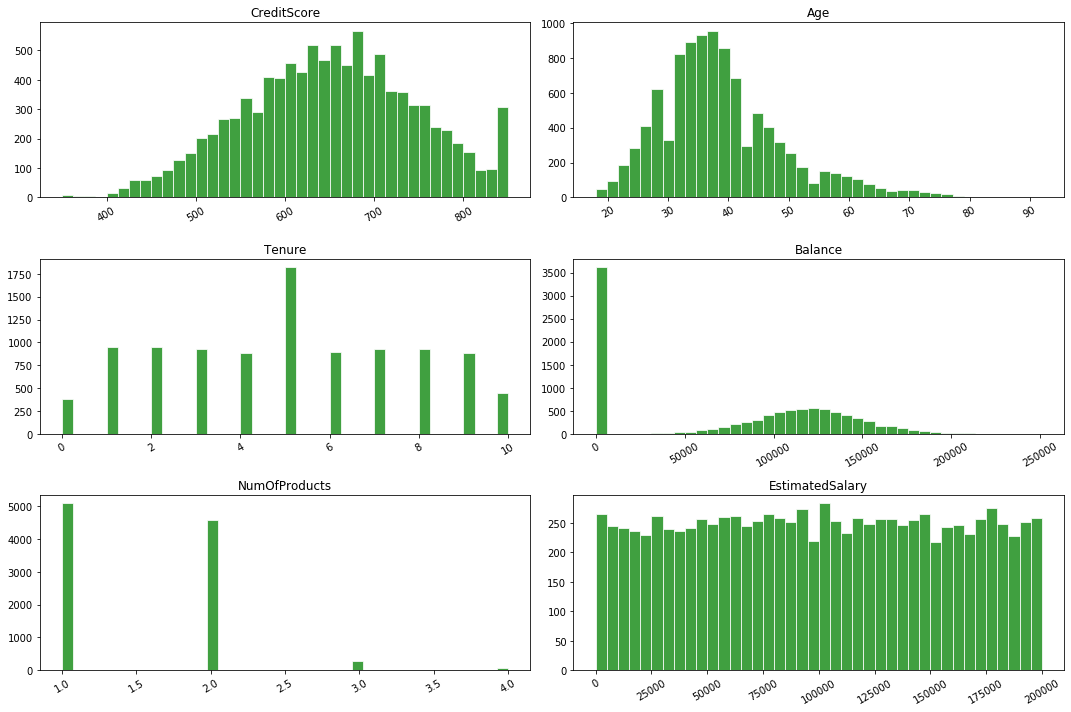

In [14]:
#Select columns to plot histograms of.
hist_columns = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

#Plot histograms to visualize distributions.
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15, 10))

for col, ax in zip(hist_columns, axs.flatten()):
    ax.hist(df[col], bins=40, color='green', density=False, alpha=.75, edgecolor='w')
    ax.set_title(col, fontsize=12)
    ax.tick_params(axis='x', labelrotation=30)

plt.tight_layout()
plt.show()

2.2 Notes: From the above statistical informatin, one might have been lead to believe that the majority of the features under consideration have normally distributed values. This is because the mean and median values for most of these features are quite close to one another. However, in normally distributed datasets, the mode is also equal to the mean and median. Since we don't see the mode represented in our statistics, we decided to visualize the value distributions for each of the features under consideration. 

As we can see from the histograms, only the 'CreditScores' feature's values appear normally distributed. Additionally, there are clear ourliers in a couple of the plots (e.g., 'Balance'). Since decision trees and random forests don't assume normal distributions, scaling wouldn't have much of an impact on their predictive abilities; however, logistic regression does assume that the data is normally distributed. 

Since normalization works by rescaling each sample (or row), it would not have the desired outcome of creating normal distributions from our features. StandardScaler, on the other, standardizes features, meaning that the values for the features we transform using the StandardScaler will have a normal distribution. As such, we will use the StandardScaler to standardize the relevant features' values. This should not have a great affect on our later decision tree and random forest models, since such models only consider one feature at a time, and the order of our features will not be altered by way of normalization.

In [15]:
#Create instance of StandardScaler class.
sc = StandardScaler()

#Fit the scaler to the training features dataset.
sc.fit(train_X[hist_columns])

#Transform the values for the same columns in all features datasets.
train_X[hist_columns] = sc.transform(train_X[hist_columns])
valid_X[hist_columns] = sc.transform(valid_X[hist_columns])
test_X[hist_columns] = sc.transform(test_X[hist_columns])

### Check the Balance of Classes<a class="anchor" id='2.3'></a>

In [16]:
#Get length of subsets of data for exited and non-exited individuals.
print("Number of clients who exited: {}".format(len(df[df['Exited']==1])))
print("Number of clients who did not exit: {}\n".format(len(df[df['Exited']==0])))

Number of clients who exited: 2037
Number of clients who did not exit: 7963



2.3 Notes: Clearly, there is a 1:4 imbalance in the number of clients who exited versus the number of clients who have not. To understand how balancing the data affects our models, we will first create models using the imbalanced dataset and compare the scores obtained to similar models trained using balanced datasets.

### Initial Testing Without Considering Class Imbalance<a class="anchor" id='2.4'></a>

In [17]:
#Create logistic regression model
LR1 = LogisticRegression(random_state=12345, solver='liblinear')
LR1.fit(train_X, train_y)

#Create decision tree model
DT1 = DecisionTreeClassifier(random_state=12345)
DT1.fit(train_X, train_y)

#Create random forest model
RF1 = RandomForestClassifier(random_state=12345)
RF1.fit(train_X, train_y)

#Create funtion to print scores
def scores(target, features, model):
    precision = precision_score(target, model.predict(features)).round(2)
    recall = recall_score(target, model.predict(features)).round(2)
    f1 = f1_score(target, model.predict(features)).round(2)
    model_name = type(model).__name__
    temp_df = pd.DataFrame([[precision, recall, f1, model_name]], columns=['Precision', 'Recall', 'F1', 'Model Type'])
    return temp_df

#Display all scores in DataFrame format.
unbalanced_data_scores = pd.concat([scores(valid_y, valid_X, LR1)] + \
                          [scores(valid_y, valid_X, DT1)] + \
                          [scores(valid_y, valid_X, RF1)]).set_index('Model Type')

display(unbalanced_data_scores)

,Precision,Recall,F1
Model Type,,,
LogisticRegression,0.63,0.22,0.33
DecisionTreeClassifier,0.49,0.51,0.50
RandomForestClassifier,0.74,0.42,0.53


2.4 Notes: In this subsection, we fit the training data to three different classification models. We then created a function, which we will use repeatedly throughout this project, that obtains a models precision, recall, and f1 score, which we then display in a DataFrame. We understand the scores obtained to represent the following:

* Precision: The ratio of true positives to the total number of positive predictions (which includes false positives). In other words, precision shows us the proportion of positive identifications that were actually correct.

* Recall: This is the measure of true positives over the sum of true positives and false negatives. In other words, recall tells us the proportion of actual positives that were correctly identified. 

* F1: This is the harmonic mean of precision and recall. The F1 score is helpful for seeking a balance between precision and recall - this is especially advantageous when there is an uneven class distribution. When the F1 score is 1, then both precision and recall are 1. 

From our unbalanced models, we see that none of them are very impressive. Whereas the logistic regression model's precision is quite high, its recall and f1 scores are very low. The decision tree classifier appears to only be correct half of the time in its positive class predictions and had only correctly identified half of the actual positive classes. Based on its having the highest f1 score, the random forest model appears to be the best at providing balanced class predictions.

In the following subsections, we will try various balanced models.

### Balanced Models<a class="anchor" id='2.5'></a>

#### Balanced Models by Class Weight<a class="anchor" id='2.5.1'></a>

In [18]:
#Create balaced logistic regression model
LR2 = LogisticRegression(random_state=12345, class_weight='balanced', solver='liblinear')
LR2.fit(train_X, train_y)

#Create balanced decision tree model
DT2 = DecisionTreeClassifier(random_state=12345, class_weight='balanced')
DT2.fit(train_X, train_y)

#Create balanced random forest model
RF2 = RandomForestClassifier(random_state=12345, class_weight='balanced')
RF2.fit(train_X, train_y)

#Display all scores in DataFrame format.
balanced_model_scores = pd.concat([scores(valid_y, valid_X, LR2)] + \
                          [scores(valid_y, valid_X, DT2)] + \
                          [scores(valid_y, valid_X, RF2)]).set_index('Model Type')

balanced_model_scores['F1 Change'] = balanced_model_scores.F1 - unbalanced_data_scores.F1

display(balanced_model_scores)

,Precision,Recall,F1,F1 Change
Model Type,,,,
LogisticRegression,0.39,0.67,0.49,0.16
DecisionTreeClassifier,0.51,0.50,0.51,0.01
RandomForestClassifier,0.73,0.42,0.53,0.00


2.5.1 Notes: In this subsection we attempted to balance the classes by using the 'class_weight' hyperparameter for each model. By passing 'balanced' as the argument, each model will provide greater weight to the under-represented class. In order to see what different such balancing has on the models' f1 scores, we added a column to our scores DataFrame which shows the new models' scores subtracted from the unbalanced models' scores. It turns out that balancing the models using the relevant hyperparameter lead to a substantially better f1 score for the logistic regression model. There was no such positive change in the f1 scores for the decision tree and random forest models. 

#### Create Upsampled and Downsampled Datasets<a class="anchor" id='2.5.2'></a>

In [19]:
#Split datasets into sets based on target class value.
train_X_zeros = train_X[train_y == 0]
train_X_ones = train_X[train_y == 1]
train_y_zeros = train_y[train_y == 0]
train_y_ones = train_y[train_y == 1]

#Concatenate datasets with those containing ones multiplied by 4 (since there is a 1:4 imbalance)
train_X_upsampled = shuffle(pd.concat([train_X_zeros] + ([train_X_ones] * 4)), random_state=12345)
train_y_upsampled = shuffle(pd.concat([train_y_zeros] + ([train_y_ones] * 4)), random_state=12345)

#Concatenate datasets with a perportionately smaller sample of those containing zeros.
train_X_downsampled = shuffle(pd.concat([train_X_zeros.sample(frac=.25, random_state=12345)] + [train_X_ones]), random_state=12345)
train_y_downsampled = shuffle(pd.concat([train_y_zeros.sample(frac=.25, random_state=12345)] + [train_y_ones]), random_state=12345)

#### Balanced Models by Upsampling<a class="anchor" id='2.5.3'></a>

In [20]:
#Create upsampled logistic regression model
LR3 = LogisticRegression(random_state=12345, solver='liblinear')
LR3.fit(train_X_upsampled, train_y_upsampled)

#Create upsampled decision tree model
DT3 = DecisionTreeClassifier(random_state=12345)
DT3.fit(train_X_upsampled, train_y_upsampled)

#Create upsampled random forest model
RF3 = RandomForestClassifier(random_state=12345)
RF3.fit(train_X_upsampled, train_y_upsampled)

#Display all scores in DataFrame format.
upsampled_model_scores = pd.concat([scores(valid_y, valid_X, LR3)] + \
                          [scores(valid_y, valid_X, DT3)] + \
                          [scores(valid_y, valid_X, RF3)]).set_index('Model Type')

upsampled_model_scores['F1 Change'] = upsampled_model_scores.F1 - balanced_model_scores.F1

display(upsampled_model_scores)

,Precision,Recall,F1,F1 Change
Model Type,,,,
LogisticRegression,0.38,0.69,0.49,0.00
DecisionTreeClassifier,0.49,0.47,0.48,-0.03
RandomForestClassifier,0.66,0.50,0.57,0.04


2.5.3 Notes: In relation to the previously balanced model, the only positive benefit that upsampling had in terms of f1 score was for the random forest model. Whereas the previous random forest model had an f1 score of .53, the same model using an upsampled training dataset has an f1 score of .57. This shows that there is a great balance between precision and recall for the upsampled random forest model. This great balance was achieved because, in relation to the previous model, this upsampled model's precision score is slightly lower and it's recall score is slightly higher. For the purpose at hand, we believe that a higher recall score is better than a higher precision score, as Beta Bank has a vested interest in finding as many individuals as possible who may terminate their contracts in the near future.

####  Balanced Models by Downsampling<a class="anchor" id='2.5.4'></a>

In [21]:
#Create downsampled logistic regression model
LR4 = LogisticRegression(random_state=12345, solver='liblinear')
LR4.fit(train_X_downsampled, train_y_downsampled)

#Create downsampled decision tree model
DT4 = DecisionTreeClassifier(random_state=12345)
DT4.fit(train_X_downsampled, train_y_downsampled)

#Create downsampled random forest model
RF4 = RandomForestClassifier(random_state=12345)
RF4.fit(train_X_downsampled, train_y_downsampled)

#Display all scores in DataFrame format.
downsampled_model_scores = pd.concat([scores(valid_y, valid_X, LR4)] + \
                          [scores(valid_y, valid_X, DT4)] + \
                          [scores(valid_y, valid_X, RF4)]).set_index('Model Type')

downsampled_model_scores['F1 Change'] = downsampled_model_scores.F1 - balanced_model_scores.F1

display(downsampled_model_scores)

,Precision,Recall,F1,F1 Change
Model Type,,,,
LogisticRegression,0.39,0.70,0.50,0.01
DecisionTreeClassifier,0.38,0.70,0.49,-0.02
RandomForestClassifier,0.50,0.69,0.58,0.05


2.5.4 Notes: Again, in relation to the models balanced using the 'class_weight' hyperparameter, downsampling only appears to provide noteworthy positive benefit for the random forest model. In relation to the model trained using an upsampled dataset, this model's f1 score is .01 point greater.

#### Balanced Models Conclusion<a class="anchor" id='2.5.5'></a>

In this section, we initially trained our models using the standard training dataset, which has a 1:4 class imbalance. We then compared the precision, recall, and f1 scores from these models to those obtained for balanced models. We balanced the models using three different methods - that is, passing 'balanced' through the 'class_weight' hyperparameter, updsampling, and downsampling. Overall, the random forest model trained using a downsampled dataset and validated using the validation dataset provided the highest f1 score. In the following section, we will attempt to obtain a higher f1 score for the random forest model trained on downsampled data by tuning various hyperparameters.

### Obtain Best Random Forest Model<a class="anchor" id='2.6'></a>

#### Tune Hyperparameters for Best Model<a class="anchor" id='2.6.1'></a>

In [22]:
best_f1 = 0
best_params = []

for estimator in range(10, 350, 20):
    for max_feature in ['auto', 'sqrt', 'log2']:
        for strap in [True, False]:
            for criteria in ['gini', 'entropy']:
                RF_model = RandomForestClassifier(n_estimators=estimator, max_features=max_feature,
                                                  bootstrap=strap, criterion=criteria, random_state=12345)
                RF_model.fit(train_X_downsampled, train_y_downsampled)
                f1 = f1_score(valid_y, RF_model.predict(valid_X))
                if f1 > best_f1:
                    best_f1 = f1
                    best_params = [estimator, max_feature, strap, criteria]
                else:
                    pass
                
#Fit model using best params
RF_Grid = RandomForestClassifier(n_estimators=best_params[0], max_features=best_params[1],
                                bootstrap=best_params[2], criterion=best_params[3], random_state=12345)

#Fit the grid with the concatenated Datasets from above.
RF_Grid.fit(train_X_downsampled, train_y_downsampled)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=270,
                       n_jobs=None, oob_score=False, random_state=12345,
                       verbose=0, warm_start=False)

In [23]:
#Display scores on validation dataset for random forest model.
display(scores(valid_y, valid_X, RF_Grid).set_index('Model Type').rename(index={'GridSearchCV' : 'Random Forest'}))

,Precision,Recall,F1
Model Type,,,
RandomForestClassifier,0.5,0.74,0.6


2.6.1 Notes: In order to iterate through various hyperparameters efficiently, we used nested for loops. In doing so, we found that the best model we obtained uses 270 trees, bootstrapping, and the gini criterion for measuring the probability of a particular variable being wrongly classified. Using this model, we achieved an f1 score of .6, which is .02 points better than the previously obtained highest f1 score for our random forest model. Better yet, the recall is .74, which demonstrates that our model was able to correctly classify approximately 3/4 of the actual positives.

#### Attempt Optimization by Threshold Moving<a class="anchor" id='2.6.2'></a>

In [24]:
#Find precision & recall values for different thresholds.
precision_rf_grid, recall_rf_grid, thresholds_rf_grid = precision_recall_curve(valid_y, RF_Grid.predict_proba(valid_X)[:, 1])

In [25]:
#Ignore last item for precision and recall, which is for graphing.
#Remove second to last, as values are 0s and returns undefined.
recall_rf_grid = recall_rf_grid[:-2]
precision_rf_grid = precision_rf_grid[:-2]

#Calculate f1 scores for each threshold using precision and recall.
f1_scores_rf_grid = (2 * recall_rf_grid * precision_rf_grid) / (recall_rf_grid + precision_rf_grid)
best_threshold = thresholds_rf_grid[np.argmax(f1_scores_rf_grid)] 
print('Best Threshold: ', best_threshold.round(2))
print('Best F1-Score: ', np.max(f1_scores_rf_grid).round(2))

Best Threshold:  0.65
Best F1-Score:  0.62


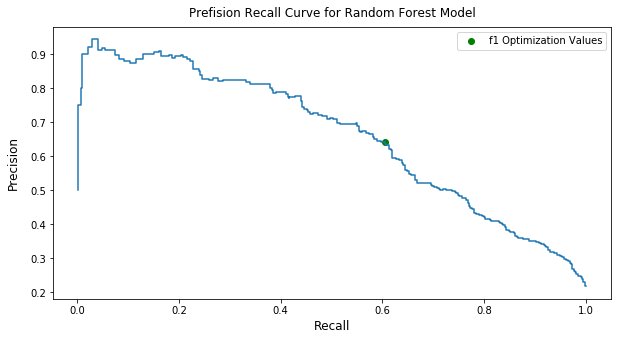

In [26]:
#Print precision recall curve with best balanced point marked.
plt.figure(figsize=(10, 5))
plt.step(recall_rf_grid, precision_rf_grid, where='post')
plt.scatter(recall_rf_grid[np.nanargmax(f1_scores_rf_grid)], precision_rf_grid[np.nanargmax(f1_scores_rf_grid)], \
            marker='o', color='green', label='f1 Optimization Values')
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12, labelpad = 10)
plt.title('Prefision Recall Curve for Random Forest Model', pad=10, fontsize=12)
plt.legend()
plt.show()

In [27]:
#Test RF_Grid model with test set and new threshold.
test_probabilities = RF_Grid.predict_proba(test_X)[:, 1]
test_predictions_new_thresh = [1 if i > best_threshold else 0 for i in test_probabilities]

print("F1-Score for test set after moving threshold: {}".format(f1_score(test_y, test_predictions_new_thresh).round(2)))
print("Recall for test set after moving threshold: {}".format(recall_score(test_y, test_predictions_new_thresh).round(2)))

F1-Score for test set after moving threshold: 0.61
Recall for test set after moving threshold: 0.63


2.6.2 Notes: In order to optimize the results of our model, we decided to change the prediction threshold value. Our hopes were that doing so would allow us to obtain a higher f1-score. In order to determine the threshold which would provide us with the highest f1-score, we first created a precision recall matrix with the validation datasets. We then used the precision and recall scores obtained to determine the f1-scores for the model at each threshold. By using numpy to find the index for the highest f1-score, we found the optimal threshold by simply taking the value for the same index at which we found the highest f1-score. 

We plotted the precision recall curve in order to visualize the efficiency of our model. In doing so, we plotted the point at which the precision and recall score values provide the optimal f1-score. With this new threshold in mind, we used our model on the test dataset. We then obtained the positive class probabilities from the model and used list comprehension to assign class labels to each value based on whether it is below or above the optimal threshold value we determined (i.e., .65). Using this method, we were able to increase our f1-score from 0.6, for the model with the standard threshold, to .61. Unfortunately, this also resulted in our recall score being reduced by .11 points, which means that fewer actual positives were identified by the model.

#### Visualize the Results - Confusion Matrices<a class="anchor" id='2.6.3'></a>

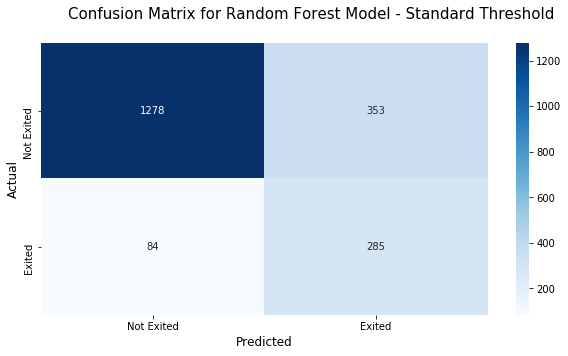

In [28]:
#Create confusion matrix to visualize the random forest's classification accuracy - standard threshold.
RF_grid_confusion_array = confusion_matrix(test_y, RF_Grid.predict(test_X))

RF_Grid_cm = pd.DataFrame(RF_grid_confusion_array, index = ['Not Exited', 'Exited'],
                  columns = ['Not Exited', 'Exited'])
plt.figure(figsize = (10,5))
sn.heatmap(RF_Grid_cm, annot=True, cmap='Blues', fmt='g')
plt.suptitle("Confusion Matrix for Random Forest Model - Standard Threshold", fontsize=15)
plt.ylabel("Actual", fontsize=12)
plt.xlabel("Predicted", fontsize=12)
plt.show()

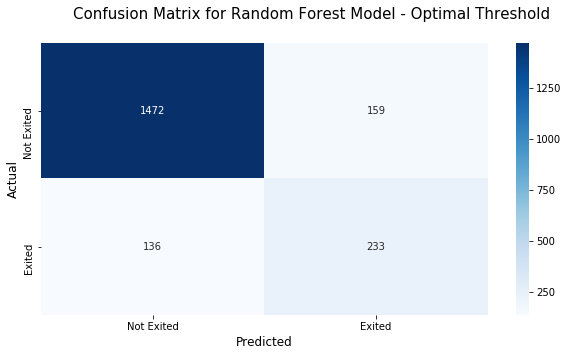

In [29]:
#Create confusion matrix to visualize the random forest's classification accuracy - new threshold.
RF_grid_confusion_array2 = confusion_matrix(test_y, test_predictions_new_thresh)

RF_Grid_cm2 = pd.DataFrame(RF_grid_confusion_array2, index = ['Not Exited', 'Exited'],
                  columns = ['Not Exited', 'Exited'])
plt.figure(figsize = (10,5))
sn.heatmap(RF_Grid_cm2, annot=True, cmap='Blues', fmt='g')
plt.suptitle("Confusion Matrix for Random Forest Model - Optimal Threshold", fontsize=15)
plt.ylabel("Actual", fontsize=12)
plt.xlabel("Predicted", fontsize=12)
plt.show()

2.6.3 Notes: From the confusion matrices, we can see that the model with the standard threshold correctly classified 52 more individuals who have exited from their Beta Bank contracts; however, the same model also incorrectly classified more people as having exited. Because of this, the models precision is lower and the f1-score is negatively affected. After increasing our threshold, we find that there are far fewer false positives than before; however, we also see that there are less true positives and more false negatives. While this has a negative impact on the recall score, in relation to the score using the standard threshold, the f1-score is increased because there is a higher balance between true positives and true negatives. 

#### Visualize the Results - ROC Graph<a class="anchor" id='2.6.4'></a>

Threshold for optimal TPR and FPR balance: 0.5


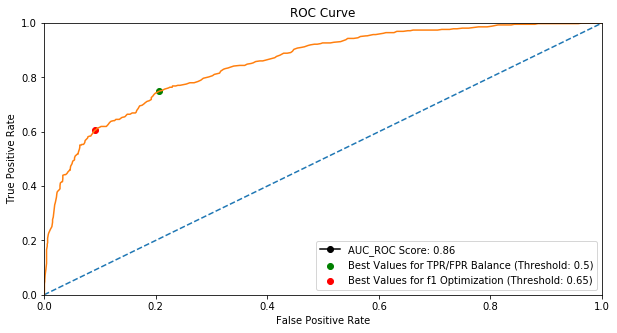

In [30]:
#Create ROC graph
fpr_rf_grid, tpr_rf_grid, thresholds = roc_curve(valid_y, RF_Grid.predict_proba(valid_X)[:, 1])

#Find optimal threshold value for ROC curve.
j_val = tpr_rf_grid - fpr_rf_grid
best_idx = np.argmax(j_val)
best_thresh_roc = thresholds[best_idx]
index_fr_threshold = np.where(thresholds == best_threshold)
print("Threshold for optimal TPR and FPR balance: {}".format(best_thresh_roc))

#Update classification labels based on new threshold.
update_probs = [1 if i > best_thresh_roc else 0 for i in test_probabilities]

#Create plot
plt.figure(figsize=(10, 5))

#Plot line for random model.
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr_rf_grid, tpr_rf_grid)
plt.scatter(fpr_rf_grid[best_idx], tpr_rf_grid[best_idx], marker='o', color='green', label='Best Values for TPR/FPR Balance (Threshold: {})'.format(best_thresh_roc,round(2)))
plt.scatter(fpr_rf_grid[index_fr_threshold], tpr_rf_grid[index_fr_threshold], marker='o', color='red', label='Best Values for f1 Optimization (Threshold: {})'.format(best_threshold.round(2)))
plt.plot(np.NaN, np.NaN, color='black', marker='o', label='AUC_ROC Score: {}'.format(roc_auc_score(test_y, test_probabilities).round(2)))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

2.6.4 Notes: In this section, we examined the roc curve in order to visualize our models performance, in terms of balancing its TPR and FPR at varying thresholds. By using the roc_auc_score function, we determined that the area under our curve is .86, which is quite a good value (the best value would be 1). 

In order to determine what the optimal threshold is for the model to balance its TPR and FPR, we used Youden's J statistic, which summarizes the performance of a diagnostic test. The values for this test range from 0 to 1, where 0 denotes a test that provides the same proportion of false positives and false negatives and where 1 denotes a perfect test. By subtracting the true positive rate from false positive rate, we can find the J statistic; by doing this for both TPR and FPR values at each threshold, we are able to find the threshold with the highest J statistic. Using this method, we found that the best threshold for balancing the true positive rate with the false positive rate .5. We plotted this point on the curve, as well as the point for the threshold we determined provides the highest f1-score. As can be seen from our graph, these thresholds do not coincide.

Based on our roc_auc score, we can conclude that our model is pretty good at distinguishing between classes, though it is far from perfect. Whereas it generally good to have a model with a balanced FPR and TPR, we believe that Beta Bank would be best served by a model that provides the highest possible recall score. Such a model might result in a worse precision score than the one's we've recently used; however, if client retention is Beta Bank's goal, we believe that having a lower precision score would be worthwhile if it means that the model is efficient at discerning actual positives.

#### Highest Recall Score<a class="anchor" id='2.6.5'></a>

In this subsection, we will find the random forest model that provides us with the highest recall score.

In [31]:
best_recall = 0
best_params_recall = []

for estimator in range(10, 350, 20):
    for max_feature in ['auto', 'sqrt', 'log2']:
        for strap in [True, False]:
            for criteria in ['gini', 'entropy']:
                RF_model = RandomForestClassifier(n_estimators=estimator, max_features=max_feature,
                                                  bootstrap=strap, criterion=criteria, random_state=123456)
                RF_model.fit(train_X_downsampled, train_y_downsampled)
                recall = recall_score(valid_y, RF_model.predict(valid_X))
                if recall > best_recall:
                    best_recall = recall
                    best_params_recall = [estimator, max_feature, strap, criteria]
                else:
                    pass
                
#Fit model using best params
RF_Grid2 = RandomForestClassifier(n_estimators=best_params[0], max_features=best_params[1],
                                bootstrap=best_params[2], criterion=best_params[3], random_state=12345)

#Fit the grid with the concatenated Datasets from above.
RF_Grid2.fit(train_X_downsampled, train_y_downsampled)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=270,
                       n_jobs=None, oob_score=False, random_state=12345,
                       verbose=0, warm_start=False)

,Precision,Recall,F1
Model Type,,,
RandomForestClassifier,0.45,0.77,0.57


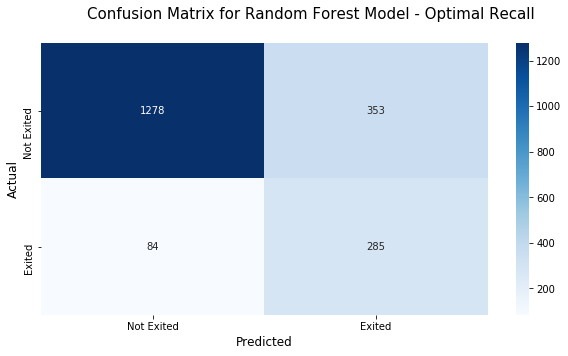

In [32]:
display(scores(test_y, test_X, RF_Grid2).set_index('Model Type').rename(index={'GridSearchCV' : 'Random Forest'}))

#Create confusion matrix to visualize the random forest's classification accuracy - standard threshold.
RF_grid_recall_confusion_array = confusion_matrix(test_y, RF_Grid2.predict(test_X))

RF_Grid_recall_cm = pd.DataFrame(RF_grid_recall_confusion_array, index = ['Not Exited', 'Exited'],
                  columns = ['Not Exited', 'Exited'])
plt.figure(figsize = (10,5))
sn.heatmap(RF_Grid_recall_cm, annot=True, cmap='Blues', fmt='g')
plt.suptitle("Confusion Matrix for Random Forest Model - Optimal Recall", fontsize=15)
plt.ylabel("Actual", fontsize=12)
plt.xlabel("Predicted", fontsize=12)
plt.show()

2.6.7 Notes: As is turns out, when iterating through the same hyperparameters as before in order to find the model with the highest recall score, the optimal model's recall score on the test dataset is .77, which is .14 points higher than the recall score for our previous model (after moving the threshold). This higher recall score, however, comes at the cost of a lower f1-score (.57, as opposed to the .61 we previously obtained).

To quickly note, we wanted to find the optimal recall score because we think it would be a better measure by which to chose an appropriate model than f1-score for Beta Bank. Assuming it does not cost much to reach out to a client in order to hopefully retain them, we believe that the best model for Beta Bank is one that correctly classifies the highest number of actual positives (i.e., those who have exited the bank). While this might result in a lower precision, if the cost of attempting to retain a client is far lower than the revenue generated by actually obtaining a client, it should not be too detrimental to reach out to those clients who are wrongly classified as about to exit. Additionally, by reaching out to such clients, Beta Bank might be able to proactively preserve their clientele - that is, perhaps prevent a client who might have considered leaving at a later date from doing so. This is, of course, only on the assumption that it is not costly to make an effort to have a client stay with the bank; depending on the cost, a very high recall score might not be best to base the model on, as it might be the result of the model classifying an overwhelming number of negatives as positives, which could end up being costly.

#### Best Model Conclusion<a class="anchor" id='2.6.6'></a>

In this section, we tested two different models using data from datasets that have been balanced through downsampling. This data was One-Hot Encoded, since the categorical variables we have are not ordinal. Our aim in this section was to find the model that provides the highest f1-score. In order to do this, we tested various models and consistently found that random forests provided the highest f1-score; this is especially true when using downsampled data. That being the case, we iterated through various hyperparameter combinations to find the model that produces the highest f1-score with the downsampled data. Without moving the threshold, we found that the best model we obtain provides us with a f1-score of .6 on the validation data set. We used the values from scikit-learn's precision_recall_curve method to test the f1-scores at various thresholds and found that having a .66 threshold provided us with an f1-score of .61 on the testing dataset.

Since we believe recall is an important measure to consider given Beta Bank's goal, we decided to find the random forest model that provides the highest recall score. As metioned, we believe that recall may be a more useful measure for Beta Bank - that is, so long as it does not cost much to attempt to retain clients who have no intention of leaving the bank anytime soon. As it turns out, the optimal recall score using the testing data was .77, which is quite high; however, this also came at the cost of reducing the f1-score by .04 points. 

## Conclusion<a class="anchor" id='3'></a>

For this project, Beta Bank instructed us to create a model that that predicts whether individuals will leave the bank soon; they desired that this model has an f1-score of at least .59. By way of properly preparing, encoding, and balancing the data, we were able to construct a model that provided an f1-score higher than .59. The scores from our models are summarized as follows:

1) RF_Grid: Model chosen for highest f1-score.
        
        ** Normal Threshold: F1 = 0.6, Recall = 74
        ** Threshold Moved (.65): F1 = .61, Recall = .63

2) RF_Grid2: Model chosen for highest recall score.

        ** Normal Threshold: F1 = .57, Recall = .77

Based on these findings, Beta Bank has various options. Clearly, the model with the highest f1-score is the RF_Grid model with a higher threshold. This model also has a recall score that indicates the model was able to accurately classify approximately 2/3 of the actual positives. If Beta Bank's cost per individual they actively try to keep with the bank is sufficiently low, they may be more interested in the RF_Grid2 model, which has a higher recall score that the other model; given it's score, it was able to accurately classify approximately 80% of actual positives. Of course, the metric that would best suit Beta Bank depends largely on the predicted cost of keeping an individual with the bank; if this cost is high, then it would certainly be better to find a model with the best precision and recall balance.